In [1]:
%%capture
!pip install dowhy==0.6

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import dowhy
import dowhy.api
import dowhy.datasets
import dowhy.plotter

# Causal Inference with DoWhy

By Alessio Zanga and Fabio Stella

## Abstract

This notebook represents a quick-start guide to causal inference using the [DoWhy](https://github.com/microsoft/dowhy) package.

## Generate a Dataset

DoWhy allows the generation of a dataset by specifying a set of parameters.

In [22]:
dataset = dowhy.datasets.linear_dataset(
    beta = 1,
    num_samples = int(1e4),
    num_common_causes = 1,
    num_frontdoor_variables = 1,
    treatment_is_binary = True,
    outcome_is_binary = True
)

list(dataset.keys())

['df',
 'treatment_name',
 'outcome_name',
 'common_causes_names',
 'instrument_names',
 'effect_modifier_names',
 'frontdoor_variables_names',
 'dot_graph',
 'gml_graph',
 'ate']

It will return a dictionary with a Pandas DataFrame, along with a set of variables names and the true causal graph used for the sampling process.

In [23]:
data, [treatment], outcome, _, _, _, _, _, causal_graph, ace = dataset.values()

After unpacking the values of the dictionary, it is possible to observe the assigned names to the data columns:

In [24]:
treatment, outcome

('v0', 'y')

It also return the true average causal effect:

In [25]:
ace

In [26]:
data

,FD0,W0,v0,y
0,1.254202,1.036302,True,False
1,-2.615143,-0.075330,False,True
2,0.200791,0.743689,False,True
3,0.067288,0.979289,False,True
4,3.071172,-0.592493,True,False
...,...,...,...,...
9995,0.208839,0.779044,False,True
9996,-1.041649,-1.003129,True,False
9997,-0.042051,-1.095407,False,True
9998,0.816487,-0.004891,True,True


## Construct a Model

The second step consists in constructing a causal model using the true graph.

In [27]:
model = dowhy.CausalModel(
    data = data,
    treatment = treatment,
    outcome = outcome,
    graph = causal_graph
)

It is not a proper SCM as we seen in previous sessions. It is more like a container for the data and the graph.

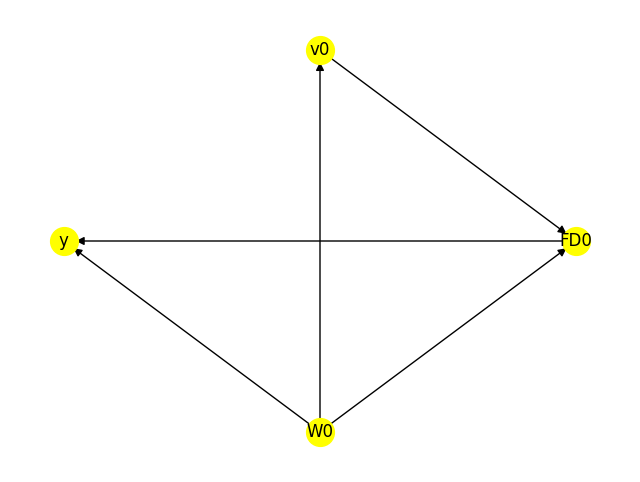

In [36]:
model.view_model(layout="dot")
#from IPython.display import Image, display    # Run these lines if you are on local.
#display(Image(filename="causal_model.png"))

This will enable the identification step by using a couple of handful methods.

## Identify the Estimand

The estimand identification tests for both backdoor and frontdoor criterion.

In [29]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the Average Causal Effect

Once the estimand has been identified, we can proceed to the last estimation step.

In [30]:
estimators = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_stratification",
    "backdoor.propensity_score_weighting",
    "backdoor.propensity_score_matching",
]

We will iterate over the provided methods and compare the results.

In [31]:
estimates = {
    estimator: model.estimate_effect(estimand, method_name=estimator)
    for estimator in estimators
}

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
propensity_score_stratification
propensity_score_weighting
propensity_score_matching


In [32]:
for estimate in estimates.values():
    print(estimate)
    break

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: -0.005485786721320274



There is an unobserved counfounder, so estimand assumption 1 does not hold! Indeed, relative errors are really high

In [33]:
for estimator, estimate in estimates.items():
    print(f"""
    Estimator: {estimator},
    Estimate: {estimate.value:.4},
    Relative Error: {(abs((estimate.value-ace)/ace*100)):.4}%
    """.lstrip("\n"))

    Estimator: backdoor.linear_regression,
    Estimate: -0.005486,
    Relative Error: 291.8%
    
    Estimator: backdoor.propensity_score_stratification,
    Estimate: -0.006908,
    Relative Error: 393.4%
    
    Estimator: backdoor.propensity_score_weighting,
    Estimate: -0.0055,
    Relative Error: 292.8%
    
    Estimator: backdoor.propensity_score_matching,
    Estimate: -0.0158,
    Relative Error: 1.029e+03%
    


## Evaluate the Results

With the estimates obtained we can setup a round of hypothesis testing.

In [37]:
refuters = [
    "bootstrap_refuter",
    "data_subset_refuter",
    "dummy_outcome_refuter",
    "placebo_treatment_refuter",
    "random_common_cause",
]

We will take the backdoor with linear regression as estimate of reference.

In [38]:
refuteds = {
    refuter: model.refute_estimate(
      estimand,
      estimates["backdoor.linear_regression"],
      method_name=refuter
    )
    for refuter in refuters
}

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

Some "refuters", as they are called in DoWhy, may return a list of tests.

We are refuting the identification of the estimand. We have not translate casual estimand in a statistical one correctly

In [39]:
for refuter in refuteds.values():
    print(refuter if type(refuter) != list else refuter[0])

Refute: Bootstrap Sample Dataset
Estimated effect:-0.005485786721320274
New effect:-0.004551812393688018
p value:0.9

Refute: Use a subset of data
Estimated effect:-0.005485786721320274
New effect:-0.005514264616428146
p value:0.96

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0002883734196379508
p value:0.96

Refute: Use a Placebo Treatment
Estimated effect:-0.005485786721320274
New effect:-0.00084342294513989
p value:0.98

Refute: Add a random common cause
Estimated effect:-0.005485786721320274
New effect:-0.005488609359700325
p value:0.94



Your results may vary. Try to experiment with different graph configurations by altering the numbers of variables in the generation step.

Have fun!